In [1]:
# Read RData
from __future__ import unicode_literals
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import json
from os import listdir, getcwd
from os.path import isfile, join
import rpy2.robjects as ro
from rpy2.robjects import numpy2ri
import numpy as np

# Read all files in a directory
mypath = getcwd()+"/data/tweet_youtube"
onlyfiles = [ join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]
tweets_time = {}
for f in onlyfiles:
    ro.r['load'](f,ro.globalenv)

shares = ro.globalenv[str('data')].rx2("numShare")
views = ro.globalenv[str('data')].rx2("dailyViewcount")

In [2]:
# Prepare data for our model

# Build a hashmap : the index of a video -> popularity_scale
# Input： a list of tuples with each element of (index, 120_totalcounts)
def build_index2popularity_scale(index2shares):
    sorted_index2shares = sorted(index2shares, key=lambda tup: tup[1]) 
    split_index2shares = np.array_split(sorted_index2shares,40)
    
    # Build a hashmap : the index of a video -> popularity_scale
    index2ps = {}
    for scale in range(40):
        for element in split_index2shares[scale]:
            index2ps[element[0]] = scale
    
    return index2ps

total_size = len(shares)
viewcounts_120 = [(index, sum(views[index][-120:])) for index in range(total_size)
                   if sum(views[index][-120:])>=100] 
real_index2ps = build_index2popularity_scale(viewcounts_120)

# # Check hashmap
#assert(max(real_index2ps.values()) == 39)
#assert(min(real_index2ps.values()) == 0)
# num = 1
# for ii in real_index2ps:
#     print(str(ii) +" "+ str(real_index2ps[ii]))
#     if num == 10:
#         break
#     else:
#         num = num + 1

In [3]:


import numpy as np
import tensorflow as tf

# Define a model

seed = 42
tf.set_random_seed(seed)

def simple_NN(s,v,hidden_size, 
              s_nclass,v_nclass, 
              s_embed_dim,v_embed_dim):
    
    # Embeddinds for discrete variables    
    with tf.variable_scope('Embeddings') as scope_em:
        try:
            embeddings_for_shares = tf.get_variable("embeddings_for_shares",
                                                    [s_nclass,s_embed_dim],
            initializer=tf.random_normal_initializer(stddev=0.5))


            embeddings_for_views = tf.get_variable("embeddings_for_views",\
                                                   [v_nclass,v_embed_dim],
            initializer=tf.random_normal_initializer(stddev=0.5))
                                                   
        except ValueError:
            scope_em.reuse_variables()
            embeddings_for_shares = tf.get_variable("embeddings_for_shares")
            embeddings_for_views = tf.get_variable("embeddings_for_views")
        
        embed_s = tf.nn.embedding_lookup(embeddings_for_shares, s)
        embed_v = tf.nn.embedding_lookup(embeddings_for_views, v)
        
#     with tf.device('/gpu:0'):
        # Define the first hidden layer
    with tf.variable_scope('Layer_1') as scope_w1:
        try:
            W_1 = tf.get_variable('W_1', [hidden_size,s_embed_dim+v_embed_dim],
            initializer=tf.random_normal_initializer(stddev=0.5))
        except ValueError:
            scope_w1.reuse_variables()
            W_1 = tf.get_variable('W_1')

        h_1 = tf.nn.sigmoid(tf.matmul(W_1, tf.concat(1,[embed_s, embed_v]), \
                                      transpose_b=True))


    # Define the first hidden layer
    with tf.variable_scope('Output') as scope_output:
        # dim of scores: vocabulary_size*batch_size
        try:
            W_ouput= tf.get_variable('W_ouput', [v_nclass,hidden_size],
            initializer=tf.random_normal_initializer(stddev=0.5))
        except ValueError:
            scope_output.reuse_variables()
            W_ouput = tf.get_variable('W_output')
        scores = tf.matmul(W_ouput, h_1)
    
    return tf.transpose(scores)


# Map the continous variable to discrete one
def map_shares_or_views(share_value, max_value):
    new_value = int(share_value/max_value*100)
    if(new_value>100):
        new_value = 100
    return(new_value)

# Placeholders
s = tf.placeholder(tf.int64, shape=[None])
v = tf.placeholder(tf.int64, shape=[None])
y = tf.placeholder(tf.int64, shape=[None])

hidden_size = 30

# Predict results
res = simple_NN(s, v, hidden_size, s_nclass, 
                v_nclass, s_embed_dim, v_embed_dim)

#correct_prediction = tf.equal(res, y)
#cost = tf.reduce_mean(correct_prediction)
#res = tf.cast(res,tf.float64)
#mse = tf.reduce_mean(tf.cast(tf.squared_difference(res,y),tf.float64))

# Define the loss function and optimization
y_one_hot = tf.one_hot(y,depth = v_nclass)
cross_entropy = tf.reduce_mean(
  tf.nn.softmax_cross_entropy_with_logits(labels=y_one_hot, logits=res))

op = tf.train.GradientDescentOptimizer(learning_rate=1).minimize(cross_entropy)

In [4]:
# 75 for training, 15 for validation and 30 for testing
def split_data(data):
    L = len(data)
    train = [ data[i] for i in range(L-120,L-30)]
    #validation = [ data[i] for i in range(L-45,L-30)]
    test = [ data[i] for i in range(L-30,L)]
    return train,test

# All values maped to [0,100]
def process_data(data):
    upper_bound = np.amax(data[-120:-30])
    return [ map_shares_or_views(i,upper_bound) for i in data]

# Prepare data set for our model
# The output format: tuple(tuple(s,v),y)
def generate_set(s,v):
    s = process_data(s)
    v = process_data(v)
    
    train_s, test_s = split_data(s)
    train_v, test_v = split_data(v)
    
    train_x_s = train_s[:-1]
    train_x_v = train_v[:-1]
    train_x = (train_x_s,train_x_v)
    train_y = train_v[1:]
    train = (train_x,train_y)
    
    test_x_s = np.append(train_s[-1],test_s[:-1])
    test_x_v = np.append(train_v[-1],test_v[:-1])
    test_x = (test_x_s,test_x_v)
    test_y = test_v
    test = (test_x,test_y)
    
    return train, test

In [ ]:
# # GPU accelerate
# from multiprocessing import Pool,cpu_count
# def loop_func(index,shares,views):
#     num_steps = 6000
    
#     s_i = np.array(shares[index])
#     v_i = np.array(views[index])
    
#     train, test = generate_set(s_i,v_i)
    
#     e = np.amax(v_i[-120:-30])

#     # Training and testing
#     session = tf.Session()

#     # Initialization
#     init = tf.global_variables_initializer()
#     session.run(init)
    
#     # Iterations for optimazting the models: training
#     for step in range(num_steps):
#         _,loss = session.run([op,cross_entropy],feed_dict={s: train[0][0], v: train[0][1], y : train[1]})
# #         if step%2000 == 0:
# #             print(loss)
#     print("Done! (training)")
    
#     # Testing
#     current_v = [test[0][1][0]]
    
#     sum_30 = 0
#     for step in range(len(test[1])):
#         output = session.run(res,feed_dict={s: [test[0][0][step]], v: current_v})
#         current_v = tf.argmax(output,1)
#         with tf.Session() as sess:
#             current_v = current_v.eval()
#             #predict.append((current_s[0]+0.5)/100*e)
#             sum_30 = sum_30 + (current_v[0]+0.5)/100*e
    
#     print("Done! (testing)")
#     with open("results2.txt", "a") as myfile:
#         myfile.write(str((index,sum_30+sum(v_i[-120:-30]))))
#     session.close()
#     return (index,sum_30+sum(v_i[-120:-30]))

# # Parallelization
# num_cores = cpu_count()
# pred = [loop_func(ele[0],shares,views) for ele in sharecounts_120]
# predicted_index2ps = build_index2popularity_scale(pred)

In [ ]:
# Parallel
from multiprocessing import Pool,cpu_count
from joblib import Parallel, delayed
import re


def loop_func(index,shares,views):
    num_steps = 12000
    
    s_i = np.array(shares[index])
    v_i = np.array(views[index])
    
    train, test = generate_set(s_i,v_i)
    
    e = np.amax(v_i[-120:-30])

    # Training and testing
    session = tf.Session()

    # Initialization
    init = tf.global_variables_initializer()
    session.run(init)
    
    # Iterations for optimazting the models: training
    for step in range(num_steps):
        _,loss = session.run([op,cross_entropy],feed_dict={s: train[0][0], v: train[0][1], y : train[1]})
#         if step%2000 == 0:
#             print(loss)
    print("Done! (training)")
    
    # Testing
    current_v = [test[0][1][0]]
    
    sum_30 = 0
    for step in range(len(test[1])):
        output = session.run(res,feed_dict={s: [test[0][0][step]], v: current_v})
        current_v = tf.argmax(output,1)
        with tf.Session() as sess:
            current_v = current_v.eval()
            #predict.append((current_s[0]+0.5)/100*e)
            sum_30 = sum_30 + (current_v[0]+0.5)/100*e
    
    print("Done! (testing)")
    total_pred_po = sum_30+sum(v_i[-120:-30])
    with open("results4.txt", "a") as myfile:
        myfile.write(str((index,total_pred_po)))
    
    return (index,total_pred_po)

# Parallelization
num_cores = cpu_count()
pred = Parallel(n_jobs=10)(delayed(loop_func)(ele[0],shares,views) \
                                  for ele in viewscounts_120)

# Resume the last program
# f = open(getcwd()+"/results2.txt","r")
# lines = f.readlines()
# lines = lines[0].strip()
# res = re.split("[\(,\) ]+", lines)
# res = [ i  for i in res if i !='']
# existing_index = [ int(res[i]) for i in range(len(res)) if i%2 == 0]
# rest_index = [ ele[0] for ele in sharecounts_120 if ele[0] not in existing_index]
# print(rest_index[:10])
# num_cores = cpu_count()
# pred = Parallel(n_jobs=num_cores)(delayed(loop_func)(index,shares,views) \
#                                   for index in rest_index)
predicted_index2ps = build_index2popularity_scale(pred)

Done! (training)
Done! (training)
Done! (training)
Done! (training)
Done! (training)
Done! (training)
Done! (training)
Done! (training)
Done! (training)
Done! (training)
Done! (training)
Done! (training)
Done! (training)
Done! (training)
Done! (training)
Done! (training)
Done! (training)
Done! (training)
Done! (training)
Done! (testing)
Done! (training)
Done! (testing)
Done! (training)
Done! (training)
Done! (training)
Done! (testing)
Done! (testing)
Done! (testing)
Done! (training)
Done! (testing)
Done! (testing)
Done! (testing)
Done! (testing)
Done! (testing)
Done! (testing)
Done! (testing)
Done! (testing)
Done! (testing)
Done! (testing)
Done! (testing)
Done! (testing)
Done! (testing)
Done! (testing)
Done! (testing)
Done! (testing)
Done! (testing)
Done! (testing)
Done! (testing)
Done! (training)
Done! (training)
Done! (training)
Done! (training)
Done! (training)
Done! (training)
Done! (training)
Done! (training)
Done! (training)
Done! (training)
Done! (training)
Done! (training)
Done

In [ ]:
# Evaluation
f = open(getcwd()+"/results2.txt","r")
lines = f.readlines()
lines = lines[0].strip()
res = re.split("[\(,\) ]+", lines)
res = [ i  for i in res if i !='']

L = len(real_index2ps)
sum_ps_error = 0
for index in real_index2ps:
    ps1 = real_index2ps[index]
    ps2 = predicted_index2ps[index]
    sum_ps_error = sum_ps_error+abs(ps1-ps2)

mean_abs_percentile_error = sum_ps_error/L/39
print(mean_abs_percentile_error)

In [ ]:
### Blank ####

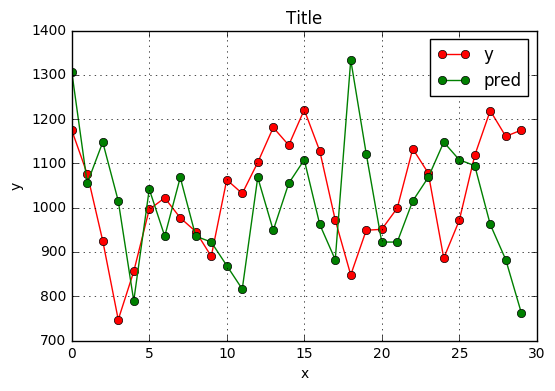

In [24]:
# Plot the predicted line and real line

# import matplotlib.pyplot as plt 

# plt.title("Title")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.plot(range(len(v_i[-30:])),v_i[-30:],'o-',color = 'r',label = "y")
# plt.plot(range(len(predict)),predict,'o-',color = 'g', label = "pred")
# plt.legend(loc = 'upper right')
# plt.grid()
# plt.show()

In [ ]:
# # draw: popularity scale
# import numpy as np

# sharecounts_120 = np.array([ sum(s[-120:]) for s in shares])
# remove_list = np.where(sharecounts_120<100)
# sharecounts_120 = np.delete(sharecounts_120, remove_list, None)

# sorted_sc_120 = np.sort(sharecounts_120)
# split_sc_120 = np.array_split(sorted_sc_120,40)

# import matplotlib.pyplot as plt
# ax = plt.subplot(111)
# ax.boxplot(split_sc_120,showfliers = False)
# ax.set_yscale('log')
# plt.show()

In [3]:
print(len(real_index2ps))

13953
